The code is taken from https://www.analyticsvidhya.com/blog/2019/11/comprehensive-guide-attention-mechanism-deep-learning/

In [1]:
import numpy as np
import pandas as pd

In [70]:
df = pd.read_csv('yelp_labelled.txt', sep='\t')
df.columns = ['review','senti']
df.head(3)

,review,senti
0,Crust is not good.,0
1,Not tasty and the texture was just nasty.,0
2,Stopped by during the late May bank holiday of...,1


In [13]:
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [14]:
corpus = df['review']

t=Tokenizer()
t.fit_on_texts(corpus)
text_matrix=t.texts_to_sequences(corpus)
# text_matrix -->
# [[585, 7, 12, 16],
#  [12, 151, 2, 1, 428, 4, 46, 429],

len_mat=[]
for i in range(len(text_matrix)):
    len_mat.append(len(text_matrix[i]))
# len_mat --> 
# [4,
#  8,
#  15,


text_pad = pad_sequences(text_matrix, maxlen=32, padding='post')

# Without Attention -- plane LSTM

In [34]:
features = 32
vocab_length = np.unique(text_pad).shape[0]
inputs1=Input(shape=(features,))
x1=Embedding(input_dim=vocab_length+1,output_dim=32,\
             input_length=features,embeddings_regularizer=keras.regularizers.l2(.001))(inputs1)
x1=LSTM(100,dropout=0.3,recurrent_dropout=0.2)(x1)
outputs1=Dense(1,activation='sigmoid')(x1)
model1=Model(inputs1,outputs1)

In [69]:
train_x, test_x, train_y, test_y = train_test_split(text_pad, df['senti'], test_size=0.33, random_state=42)
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model1.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 32, 32)            66336     
_________________________________________________________________
lstm (LSTM)                  (None, 100)               53200     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 119,637
Trainable params: 119,637
Non-trainable params: 0
_________________________________________________________________


In [45]:
model1.fit(x=train_x,y=train_y,batch_size=100,epochs=10,verbose=1,shuffle=True,validation_split=0.2)

Epoch 1/10


C:\Users\Sanjay\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


6/6 [==============================] - 1s 84ms/step - loss: 0.7437 - accuracy: 0.4841 - val_loss: 0.7332 - val_accuracy: 0.4701
Epoch 2/10
6/6 [==============================] - 0s 37ms/step - loss: 0.7274 - accuracy: 0.4561 - val_loss: 0.7174 - val_accuracy: 0.5299
Epoch 3/10
6/6 [==============================] - 0s 36ms/step - loss: 0.7147 - accuracy: 0.5084 - val_loss: 0.7076 - val_accuracy: 0.5299
Epoch 4/10
6/6 [==============================] - 0s 36ms/step - loss: 0.7065 - accuracy: 0.5084 - val_loss: 0.7019 - val_accuracy: 0.5299
Epoch 5/10
6/6 [==============================] - 0s 36ms/step - loss: 0.7008 - accuracy: 0.5084 - val_loss: 0.6978 - val_accuracy: 0.5299
Epoch 6/10
6/6 [==============================] - 0s 36ms/step - loss: 0.6975 - accuracy: 0.5084 - val_loss: 0.6951 - val_accuracy: 0.5299
Epoch 7/10
6/6 [==============================] - 0s 36ms/step - loss: 0.6953 - accuracy: 0.5084 - val_loss: 0.6935 - val_accuracy: 0.5299
Epoch 8/10
6/6 [======================

# Now using Attention mechanism

custom layers which inherit Layer class should have build(),call (), compute_output_shape() and get_config().

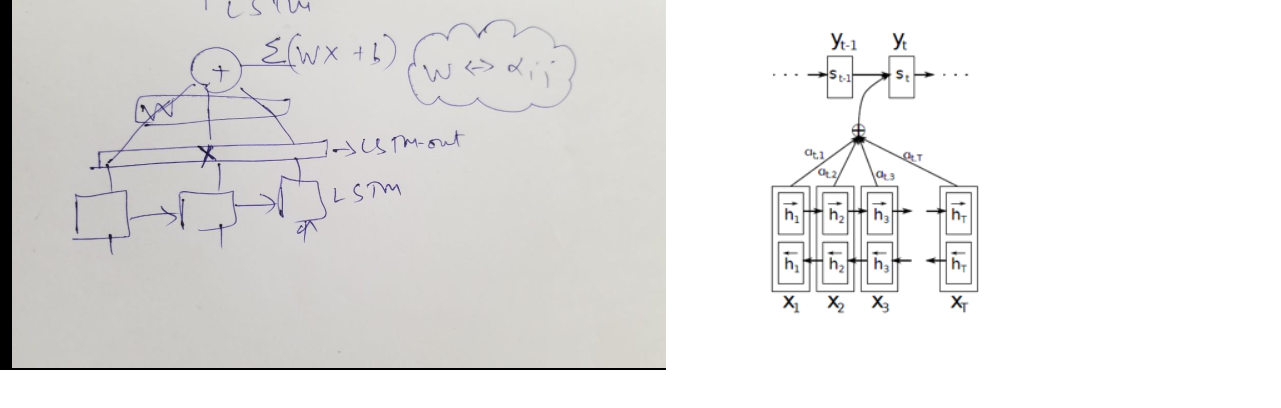

In [68]:
from IPython.display import Image
Image(filename='atten_senti.png')

In [63]:
from tensorflow.keras.layers import Layer

class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        super(attention, self).build(input_shape)

    def call(self,x):
        et=tf.squeeze(tf.tanh(tf.matmul(x,self.W)+self.b),axis=-1)
        at=tf.nn.softmax(et)
        at=tf.expand_dims(at,axis=-1)
        output=x*at
        return tf.math.reduce_sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()

In [64]:
inputs=Input((features,))
x=Embedding(input_dim=vocab_length+1,output_dim=32,input_length=features,\
            embeddings_regularizer=keras.regularizers.l2(.001))(inputs)
att_in=LSTM(100,return_sequences=True,dropout=0.3,recurrent_dropout=0.2)(x)
att_out=attention()(att_in)
outputs=Dense(1,activation='sigmoid',trainable=True)(att_out)
model=Model(inputs,outputs)
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 32, 32)            66336     
_________________________________________________________________
lstm_6 (LSTM)                (None, 32, 100)           53200     
_________________________________________________________________
attention_5 (attention)      (None, 100)               132       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 119,769
Trainable params: 119,769
Non-trainable params: 0
_________________________________________________________________


In [65]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model.fit(x=train_x,y=train_y,batch_size=100,epochs=10,verbose=1,shuffle=True,validation_split=0.2)

Epoch 1/10
6/6 [==============================] - 0s 74ms/step - loss: 0.7432 - acc: 0.4879 - val_loss: 0.7326 - val_acc: 0.4701
Epoch 2/10
6/6 [==============================] - 0s 39ms/step - loss: 0.7268 - acc: 0.4804 - val_loss: 0.7166 - val_acc: 0.5299
Epoch 3/10
6/6 [==============================] - 0s 39ms/step - loss: 0.7143 - acc: 0.5084 - val_loss: 0.7059 - val_acc: 0.5299
Epoch 4/10
6/6 [==============================] - 0s 37ms/step - loss: 0.7052 - acc: 0.5178 - val_loss: 0.6998 - val_acc: 0.5746
Epoch 5/10
6/6 [==============================] - 0s 37ms/step - loss: 0.6982 - acc: 0.5477 - val_loss: 0.6930 - val_acc: 0.5821
Epoch 6/10
6/6 [==============================] - 0s 39ms/step - loss: 0.6874 - acc: 0.6093 - val_loss: 0.6688 - val_acc: 0.6343
Epoch 7/10
6/6 [==============================] - 0s 39ms/step - loss: 0.5973 - acc: 0.7308 - val_loss: 0.6787 - val_acc: 0.6119
Epoch 8/10
6/6 [==============================] - 0s 39ms/step - loss: 0.5015 - acc: 0.7813 - val

 See how the validation accuracy improved!!!